# 09. Aggregated HDBSCAN Clustering

HDBSCAN clustering at three aggregation levels:
1. **Buyers** - cluster buyers by procurement behavior patterns
2. **Suppliers** - cluster suppliers by winning patterns (detect cartels)
3. **Buyer-Supplier Pairs** - cluster relationships (detect collusion)

In [1]:
import sys
sys.path.insert(0, '..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from src.data_loader import load_tenders, load_buyers, load_suppliers
from src.detectors import AggregatedHDBSCAN

pd.set_option('display.max_columns', 50)
plt.style.use('seaborn-v0_8-whitegrid')

print(f"Started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Started: 2026-02-08 14:29:20


## 1. Load Data

In [2]:
tenders = load_tenders(years=[2022, 2023, 2024, 2025])
buyers = load_buyers()
suppliers = load_suppliers()

print(f"Tenders: {len(tenders):,}")
print(f"Buyers: {len(buyers):,}")
print(f"Suppliers: {len(suppliers):,}")

Scanning 2022...
Scanning 2023...
Scanning 2024...
Scanning 2025...
Loaded 12,877,960 records
Loaded buyers: 35,995
Loaded suppliers: 358,376
Tenders: 12,877,960
Buyers: 35,995
Suppliers: 358,376


## 2. Initialize Detector

In [3]:
detector = AggregatedHDBSCAN(
    min_cluster_size=10,
    min_samples=5,
    metric="euclidean",
)

## 3. Cluster Buyers

Find groups of buyers with similar procurement patterns. Outliers = suspicious buyers.

In [4]:
buyer_results = detector.cluster_buyers(tenders, buyers)

Clustering BUYERS...
  Using pre-computed buyer features
  Features: ['single_bidder_rate', 'competitive_rate', 'avg_discount_pct', 'supplier_diversity_index', 'total_tenders', 'total_value']
  Buyers: 35,995
  Clusters: 440
  Noise (outliers): 19,105 (53.1%)
  Anomalies (top 5%): 1,799 (5.0%)


In [5]:
print("\nBuyer clustering results:")
print(f"  Total buyers: {len(buyer_results):,}")
print(f"  Clusters: {buyer_results['cluster'].nunique() - 1}")
print(f"  Noise (outliers): {buyer_results['is_noise'].sum():,}")
print(f"  Anomalies: {buyer_results['is_anomaly'].sum():,}")


Buyer clustering results:
  Total buyers: 35,995
  Clusters: 440
  Noise (outliers): 19,105
  Anomalies: 1,799


In [6]:
# Suspicious buyers (high outlier score)
suspicious_buyers = detector.get_suspicious_buyers(min_score=0.5)
print(f"\nSuspicious buyers (score >= 0.5): {len(suspicious_buyers):,}")

if len(suspicious_buyers) > 0:
    print("\nTop 10 by outlier score:")
    display(suspicious_buyers.nlargest(10, 'outlier_score'))


Suspicious buyers (score >= 0.5): 19,654

Top 10 by outlier score:


,buyer_id,cluster,probability,outlier_score,is_noise,is_anomaly,single_bidder_rate,competitive_rate,avg_discount_pct,supplier_diversity_index,total_tenders,total_value
0,40295882,-1,0.0,1.0,1,1,0.000334,0.000788,0.042697,0.016495,64226,3.201191e+09
1,38357766,-1,0.0,1.0,1,1,0.001007,0.003526,0.117540,0.073036,34945,2.950025e+08
2,39776588,-1,0.0,1.0,1,1,0.001285,0.001820,0.048113,0.103330,14186,2.832284e+08
3,41076819,-1,0.0,1.0,1,1,0.000161,0.000000,0.000515,0.071337,13377,2.187065e+08
4,38313100,-1,0.0,1.0,1,1,0.000000,0.000000,0.000000,0.000000,12330,3.961513e+07
5,38351628,-1,0.0,1.0,1,1,0.000246,0.003197,0.075250,0.130841,10927,1.745288e+08
6,03767831,-1,0.0,1.0,1,1,0.000000,0.000000,0.000000,0.000000,10052,2.614186e+09
7,21560045,-1,0.0,1.0,1,1,0.160263,0.240647,6.656740,0.452477,9972,1.779480e+10
8,38324552,-1,0.0,1.0,1,1,0.000000,0.000000,0.000000,0.000000,9708,2.906917e+07
9,19122935,-1,0.0,1.0,1,1,0.005405,0.015135,0.328641,0.033153,9699,9.233682e+07


In [7]:
# Compare suspicious vs normal buyers
if len(suspicious_buyers) > 0 and 'single_bidder_rate' in buyer_results.columns:
    normal_buyers = buyer_results[buyer_results['outlier_score'] < 0.5]
    
    print("Comparison: Suspicious vs Normal Buyers")
    print("="*50)
    
    for col in ['single_bidder_rate', 'competitive_rate', 'total_value']:
        if col in buyer_results.columns:
            sus_mean = suspicious_buyers[col].mean()
            norm_mean = normal_buyers[col].mean()
            print(f"{col}:")
            print(f"  Suspicious: {sus_mean:.3f}")
            print(f"  Normal:     {norm_mean:.3f}")

Comparison: Suspicious vs Normal Buyers
single_bidder_rate:
  Suspicious: 0.053
  Normal:     0.013
competitive_rate:
  Suspicious: 0.051
  Normal:     0.016
total_value:
  Suspicious: 172465013.332
  Normal:     26270667.744


## 4. Cluster Suppliers

Find groups of suppliers with similar winning patterns. Outliers = potential cartel members or anomalous suppliers.

In [8]:
supplier_results = detector.cluster_suppliers(tenders, suppliers)

Clustering SUPPLIERS...
  Computing supplier features from tenders (Polars)...
  Features: ['total_awards', 'total_value', 'avg_award_value', 'buyer_count', 'single_bidder_rate', 'avg_competitors']
  Suppliers: 358,377
  Clusters: 9506
  Noise (outliers): 101,006 (28.2%)
  Anomalies (top 5%): 17,918 (5.0%)


In [9]:
print("\nSupplier clustering results:")
print(f"  Total suppliers: {len(supplier_results):,}")
print(f"  Clusters: {supplier_results['cluster'].nunique() - 1}")
print(f"  Noise (outliers): {supplier_results['is_noise'].sum():,}")
print(f"  Anomalies: {supplier_results['is_anomaly'].sum():,}")


Supplier clustering results:
  Total suppliers: 358,377
  Clusters: 9506
  Noise (outliers): 101,006
  Anomalies: 17,918


In [10]:
# Suspicious suppliers
suspicious_suppliers = detector.get_suspicious_suppliers(min_score=0.5)
print(f"\nSuspicious suppliers (score >= 0.5): {len(suspicious_suppliers):,}")

if len(suspicious_suppliers) > 0:
    print("\nTop 10 by outlier score:")
    display(suspicious_suppliers.nlargest(10, 'outlier_score'))


Suspicious suppliers (score >= 0.5): 126,978

Top 10 by outlier score:


,supplier_id,cluster,probability,outlier_score,is_noise,is_anomaly,total_awards,total_value,avg_award_value,buyer_count,single_bidder_rate,avg_competitors
3,387641513057,2264,0.0,1.0,0,1,1,14697.00,1.469700e+04,1,0.000000,0.000000
5,22437679,245,0.0,1.0,0,1,1,151.80,1.518000e+02,1,0.000000,0.000000
6,39417349,-1,0.0,1.0,1,1,1054,35441064.59,3.362530e+04,272,0.039848,0.426945
7,3299117836,-1,0.0,1.0,1,1,8,300575.50,3.757194e+04,1,0.000000,0.000000
9,37436506,-1,0.0,1.0,1,1,199,54892090.33,2.758396e+05,44,0.115578,0.125628
11,38877069,-1,0.0,1.0,1,1,10,11101513.73,1.110151e+06,3,0.700000,0.900000
16,2468100173,-1,0.0,1.0,1,1,33,313421.00,9.497606e+03,2,0.000000,0.000000
19,2975205429,-1,0.0,1.0,1,1,1,3547.83,3.547830e+03,1,0.000000,0.000000
20,3565908011,-1,0.0,1.0,1,1,84,6745232.00,8.030038e+04,10,0.083333,0.107143
21,2569709030,-1,0.0,1.0,1,1,11,1538499.93,1.398636e+05,7,0.181818,0.454545


In [11]:
# Supplier clusters analysis
print("\nSupplier Cluster Analysis:")
print("="*50)

cluster_stats = supplier_results.groupby('cluster').agg({
    'supplier_id': 'count',
    'total_awards': 'mean',
    'total_value': 'mean',
    'single_bidder_rate': 'mean',
}).round(2)
cluster_stats.columns = ['count', 'avg_awards', 'avg_value', 'single_bidder_rate']
cluster_stats = cluster_stats.sort_values('count', ascending=False)

display(cluster_stats.head(10))


Supplier Cluster Analysis:


,count,avg_awards,avg_value,single_bidder_rate
cluster,,,,
-1,101006,97.78,36052080.09,0.09
9226,3041,46.31,668089.70,0.00
9249,2252,40.09,636966.30,0.00
9269,1962,56.11,694154.72,0.00
9290,1644,53.61,765092.79,0.00
2487,1003,1.00,10000.00,0.00
9320,947,51.42,722074.54,0.00
2747,887,1.00,5000.00,0.00
3299,817,1.00,20000.00,0.00


## 5. Cluster Buyer-Supplier Pairs

Find groups of relationships with similar patterns. Outliers = suspicious collusive relationships.

In [12]:
pair_results = detector.cluster_pairs(tenders, min_contracts=3)

Clustering BUYER-SUPPLIER PAIRS...
  Computing pair features from tenders (Polars)...
  Pairs with 3+ contracts: 916,278
  Features: ['contracts_count', 'total_value', 'avg_value', 'single_bidder_rate', 'exclusivity_buyer', 'exclusivity_supplier']
  Clusters: 8545
  Noise (outliers): 639,977 (69.8%)
  Anomalies (top 5%): 45,813 (5.0%)


In [13]:
if len(pair_results) > 0:
    print("\nBuyer-Supplier pair clustering results:")
    print(f"  Total pairs: {len(pair_results):,}")
    print(f"  Clusters: {pair_results['cluster'].nunique() - 1}")
    print(f"  Noise (outliers): {pair_results['is_noise'].sum():,}")
    print(f"  Anomalies: {pair_results['is_anomaly'].sum():,}")


Buyer-Supplier pair clustering results:
  Total pairs: 916,278
  Clusters: 8545
  Noise (outliers): 639,977
  Anomalies: 45,813


In [14]:
# Suspicious pairs (potential collusion)
if len(pair_results) > 0:
    suspicious_pairs = detector.get_suspicious_pairs(min_score=0.5)
    print(f"\nSuspicious pairs (score >= 0.5): {len(suspicious_pairs):,}")

    if len(suspicious_pairs) > 0:
        print("\nTop 10 suspicious pairs by outlier score:")
        display(suspicious_pairs.nlargest(10, 'outlier_score')[[
            'buyer_id', 'supplier_id', 'outlier_score', 
            'contracts_count', 'total_value', 'single_bidder_rate',
            'exclusivity_buyer', 'exclusivity_supplier'
        ]])


Suspicious pairs (score >= 0.5): 640,612

Top 10 suspicious pairs by outlier score:


,buyer_id,supplier_id,outlier_score,contracts_count,total_value,single_bidder_rate,exclusivity_buyer,exclusivity_supplier
0,14292928,2299810816,1.0,4,44534.00,0.000000,0.030303,0.400000
1,40235671,30928420,1.0,4,301456.00,0.000000,0.002924,0.015152
3,26630907,32490244,1.0,3,974989.50,0.000000,0.003158,0.000014
9,40703235,38154604,1.0,10,408012.00,0.000000,0.004158,0.277778
11,43930375,38228199,1.0,5,26982.22,0.000000,0.010893,0.017065
12,34512809,39469334,1.0,18,1390701.10,0.111111,0.039560,0.060201
13,40108604,30887436,1.0,3,5327125.36,0.000000,0.001212,0.071429
14,43917160,36435962,1.0,3,954.72,0.000000,0.001423,0.008746
15,02498487,42186176,1.0,5,4692457.75,0.000000,0.050505,0.500000
16,13762094,39764457,1.0,14,222792.22,0.000000,0.045455,0.021212


In [15]:
# Highly exclusive relationships (potential red flags)
if len(pair_results) > 0:
    exclusive_pairs = pair_results[
        (pair_results['exclusivity_buyer'] > 0.5) | 
        (pair_results['exclusivity_supplier'] > 0.5)
    ]
    print(f"\nHighly exclusive relationships (>50% exclusivity): {len(exclusive_pairs):,}")
    
    if len(exclusive_pairs) > 0:
        print("\nTop 10 by buyer exclusivity:")
        display(exclusive_pairs.nlargest(10, 'exclusivity_buyer')[[
            'buyer_id', 'supplier_id', 'contracts_count', 'total_value',
            'exclusivity_buyer', 'exclusivity_supplier', 'single_bidder_rate'
        ]])


Highly exclusive relationships (>50% exclusivity): 92,216

Top 10 by buyer exclusivity:


,buyer_id,supplier_id,contracts_count,total_value,exclusivity_buyer,exclusivity_supplier,single_bidder_rate
7473,26638846,88888888,21,1728624.2,1.0,0.000323,0.0
8782,40684841,31888247,3,136800.0,1.0,0.050847,0.0
10123,40546610,2165811626,3,483408.0,1.0,1.000000,0.0
11181,41686698,3191507671,5,569900.0,1.0,0.086207,0.0
13442,45725630,2917900234,4,18549.0,1.0,0.006623,0.0
32133,44042631,44314547,3,899982.0,1.0,0.022556,0.0
39019,40180900,2983508064,6,9270.6,1.0,0.069767,0.0
45264,26342287,2875612351,11,549438.0,1.0,1.000000,0.0
46789,43955068,43955068,4,100150.0,1.0,1.000000,0.0
49069,36229300,41259667,3,1257082.0,1.0,0.093750,0.0


## 6. Summary

In [16]:
summaries = detector.summary()

for level, summary_df in summaries.items():
    print(f"\n{level.upper()} Summary:")
    print("="*40)
    display(summary_df)


BUYERS Summary:


,metric,value
0,total,35995.000000
1,clusters,441.000000
2,noise,19105.000000
3,noise_pct,53.076816
4,anomalies,1799.000000
5,anomaly_pct,4.997916



SUPPLIERS Summary:


,metric,value
0,total,358377.000000
1,clusters,9507.000000
2,noise,101006.000000
3,noise_pct,28.184286
4,anomalies,17918.000000
5,anomaly_pct,4.999763



PAIRS Summary:


,metric,value
0,total,916278.000000
1,clusters,8546.000000
2,noise,639977.000000
3,noise_pct,69.845287
4,anomalies,45813.000000
5,anomaly_pct,4.999902


## 7. Visualizations

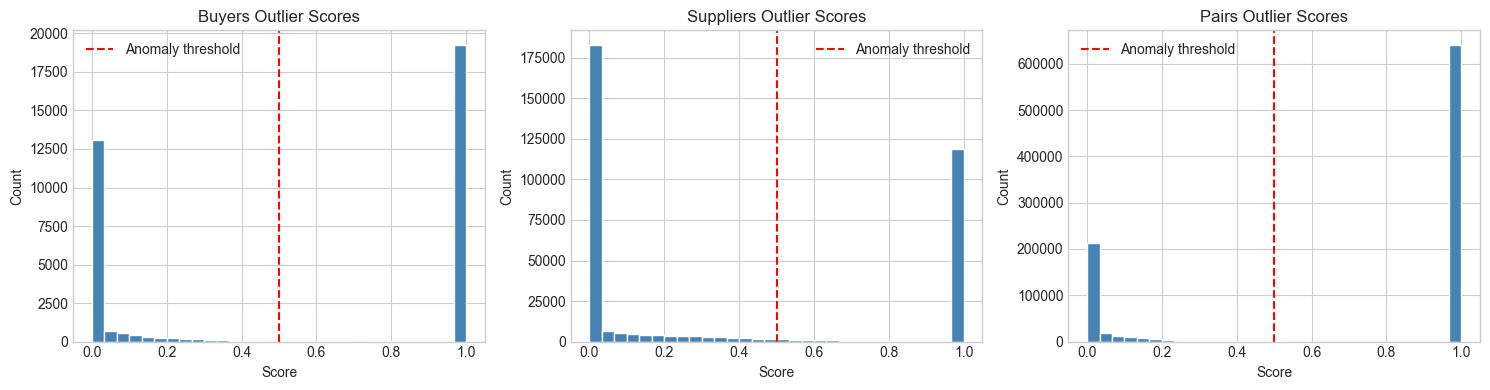

In [17]:
# Outlier score distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, (name, results) in zip(axes, [
    ('Buyers', detector.buyer_results_),
    ('Suppliers', detector.supplier_results_),
    ('Pairs', detector.pair_results_),
]):
    if results is not None and len(results) > 0:
        results['outlier_score'].hist(bins=30, ax=ax, color='steelblue', edgecolor='white')
        ax.axvline(x=0.5, color='red', linestyle='--', label='Anomaly threshold')
        ax.set_title(f'{name} Outlier Scores')
        ax.set_xlabel('Score')
        ax.set_ylabel('Count')
        ax.legend()
    else:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center')
        ax.set_title(f'{name} Outlier Scores')

plt.tight_layout()
plt.savefig('../results/aggregated_hdbscan_scores.png', dpi=150, bbox_inches='tight')
plt.show()

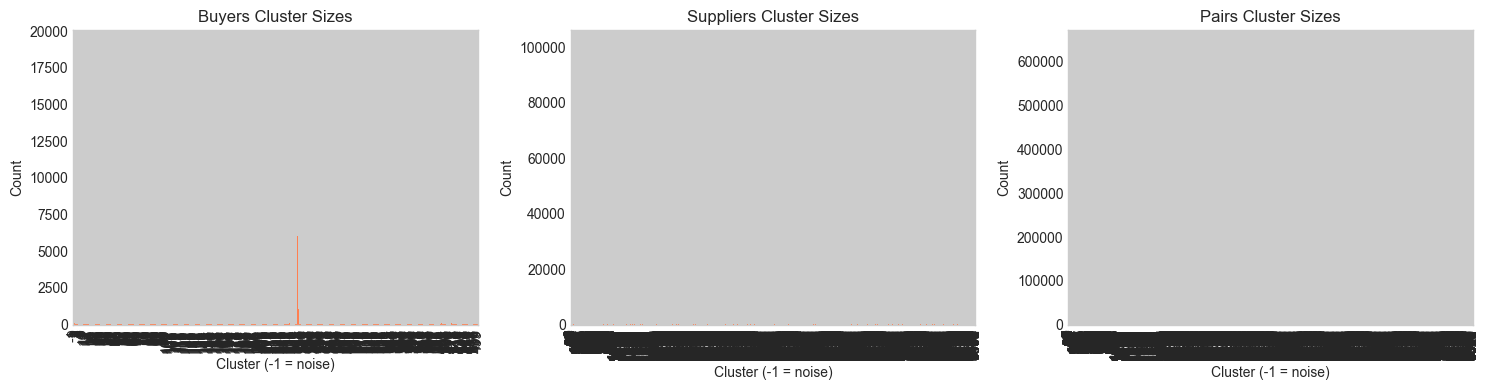

In [18]:
# Cluster sizes
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, (name, results) in zip(axes, [
    ('Buyers', detector.buyer_results_),
    ('Suppliers', detector.supplier_results_),
    ('Pairs', detector.pair_results_),
]):
    if results is not None and len(results) > 0:
        cluster_sizes = results['cluster'].value_counts().sort_index()
        cluster_sizes.plot(kind='bar', ax=ax, color='coral')
        ax.set_title(f'{name} Cluster Sizes')
        ax.set_xlabel('Cluster (-1 = noise)')
        ax.set_ylabel('Count')
    else:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center')
        ax.set_title(f'{name} Cluster Sizes')

plt.tight_layout()
plt.savefig('../results/aggregated_hdbscan_clusters.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Save Results

In [19]:
# Save anomalies from each level
if detector.buyer_results_ is not None:
    suspicious_buyers = detector.get_suspicious_buyers(0.5)
    suspicious_buyers.to_csv('../results/hdbscan_suspicious_buyers.csv', index=False)
    print(f"Saved {len(suspicious_buyers)} suspicious buyers")

if detector.supplier_results_ is not None:
    suspicious_suppliers = detector.get_suspicious_suppliers(0.5)
    suspicious_suppliers.to_csv('../results/hdbscan_suspicious_suppliers.csv', index=False)
    print(f"Saved {len(suspicious_suppliers)} suspicious suppliers")

if detector.pair_results_ is not None and len(detector.pair_results_) > 0:
    suspicious_pairs = detector.get_suspicious_pairs(0.5)
    suspicious_pairs.to_csv('../results/hdbscan_suspicious_pairs.csv', index=False)
    print(f"Saved {len(suspicious_pairs)} suspicious pairs")

print(f"\nCompleted: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Saved 19654 suspicious buyers
Saved 126978 suspicious suppliers
Saved 640612 suspicious pairs

Completed: 2026-02-08 14:32:22
